# Tutorial: The Canonical HANK Model in an Open Economy Setting

NBER Heterogeneous-Agent Macro Workshop

Michael Cai and Ludwig Straub

Spring 2022

We begin once more by importing packages.

In [179]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import sequence_jacobian as sj

We again set the calibration up front.

In [180]:
calibration = {'eis': 1.,  # elasticity of intertemporal substitution
               'alpha': 0.4,  # home's foreign good preference, (1 - alpha) is the home's home bias
               'alphastar': 0.4,  # foreign's home good preference, (1 - alpha_star) is the foreign's home bias
               'eta': 1.01,  # elasticity of substitution between goods
               'gamma': 0.394,  # elasticity of foreign demand
               'markup_ss': 1.015,  # steady state markup
               'min_a': 0.,  # Minimum asset level on the grid
               'max_a': 400,  # Maximum asset level on the grid
               'n_a': 200,  # Number of asset grid points
               'rho_e': 0.92,  # persistence of idiosyncratic productivity shocks
               'sd_e': 0.57,  # standard deviation of idiosyncratic productivity shocks
               'n_e': 7,  # Number of income grid points
               'Y': 1,  # Output
               'A': 1,
               'C': 1,
               'nfa': 0,  # net foreign assets
               'rstar': 0.02,  # foreign interest rate
               'Cstar': 1,
               'Q': 1}  # Foreign demand

## Model setup

### `HetBlock` as before

We begin with the household block, which is defined exactly like we used it before! [copy & paste]

In [181]:
# initialize
def hh_init(a_grid, z, r, eis):
    coh = (1 + r) * a_grid[np.newaxis, :] + z[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    return Va

# backward step
@sj.het(exogenous='Pi',  # <-- this means our transition matrix will be fed into the model as Pi
        policy='a',  # <-- this means our endogenous state variable is a, defined over grid a_grid
        backward='Va',  # <-- this means we're iterating over variable Va, whose future value is Va_p
        backward_init=hh_init)
def hh(Va_p, a_grid, z, r, beta, eis):
    uc_nextgrid = beta * Va_p  # u'(c') on tomorrow's grid
    c_nextgrid = uc_nextgrid ** (-eis)  # c' on tomorrow's grid
    coh = (1 + r) * a_grid[np.newaxis, :] + z[:, np.newaxis]  # cash on hand coh on today's grid
    a = sj.interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)  # this plots (c'+a', a') pairs and computes policy a from interpolation on coh
    sj.misc.setmin(a, a_grid[0])  # impose borrowing constraint
    c = coh - a  # back out consumption
    Va = (1 + r) * c ** (-1 / eis)  # V'(a)
    return Va, a, c

Just like before, we set two `hetinputs` and a `hetoutput` for calculating MPCs. [copy & paste]

In [182]:
def make_grids(rho_e, sd_e, n_e, min_a, max_a, n_a):
    e_grid, _, Pi = sj.grids.markov_rouwenhorst(rho_e, sd_e, n_e)
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a)
    return e_grid, Pi, a_grid

def income(Z, e_grid):
    z = Z * e_grid
    return z

hh_ha = hh.add_hetinputs([make_grids, income])

### Other blocks

Here we list a few extra `SimpleBlock`s we need:

 - sectoral demand of domestic households:

In [183]:
@sj.simple
def dom_demand(C, PF_P, PH_P, eta, alpha):
    cH = (1 - alpha) * PH_P ** (-eta) * C  # PH_P is the real (in domestic cons. good units) price of the home good consumed domestically
    cF = alpha * PF_P ** (-eta) * C  # PF_P is the real (in domestic cons. good units) price of the foreign good consumed domestically
    return cH, cF

 - foreign demand

In [184]:
@sj.simple
def for_demand(PHstar, alphastar, gamma, Cstar):
    cHstar = alphastar * PHstar ** (-gamma) * Cstar  # PHstar is the real (in domestic cons. good units) price of the home good consumed abroad
    return cHstar

 - UIP

In [185]:
@sj.solved(unknowns={'Q': (0.01, 3.)}, targets=['uip'])
def UIP(Q, r_ante, rstar, eta, alpha, gamma):
    # recursive equation for UIP to pin down RER Q
    uip = 1 + r_ante - (1 + rstar) * Q(1) / Q
    
    # price of H goods abroad in terms of Q
    PHstar = ((Q ** (eta - 1) - alpha) / (1 - alpha)) ** (1 / (1 - eta))
    
    # price of H goods at home in terms of Q
    PH_P = ((1 - alpha * Q ** (1 - eta)) / (1 - alpha)) ** (1 / (1 - eta))
    
    # price of F goods at home in terms of Q
    PF_P = Q  # LOOP
    
    # let's also compute chi, as an important object in the theory
    chi = eta * (1-alpha) + gamma
    return uip, PHstar, PH_P, PF_P, chi

 - income

In [186]:
@sj.solved(unknowns={'J': (0.001, 15.)}, targets=['valuation_cond'])
def income(Y, PH_P, J, r_ante, markup_ss):
    # real labor income
    Z = 1 / markup_ss * PH_P * Y
    
    # real dividend
    div = (1 - 1 / markup_ss) * PH_P * Y   
    
    # nominal PPP adjusted GDP
    gdp = PH_P * Y
    
    # valuation condition to price the asset
    valuation_cond = div + J(1) / (1 + r_ante) - J  # J = beginning of period valuation
    j = J(1) / (1 + r_ante)  # j = end of period valuation
    
    # ex post interest rate incl revaluation
    r = J / j(-1) - 1
    return j, valuation_cond, gdp, div, Z, r

 - balance of payments: (just to compute the NFA, not needed if we clear the goods market)

In [187]:
@sj.solved(unknowns={'nfa': (-5., 5.)}, targets=['nfa_cond'])
def bop(nfa, PH_P, cHstar, PF_P, cF, r_ante):
    NX = PH_P * cHstar - PF_P * cF  # PH_P * Y - PF_P * cF - PH_P * cH
    nfa_cond = NX + (1 + r_ante(-1)) * nfa(-1) - nfa
    return NX, nfa_cond

 - market clearing

In [188]:
@sj.simple
def mkt_clearing(Y, cH, cHstar, A, nfa, j):
    goods_mkt = cH + cHstar - Y
    asset_mkt = A - nfa - j
    return goods_mkt, asset_mkt

In [189]:
ha = sj.create_model([UIP, income, hh_ha, dom_demand, for_demand, bop,  mkt_clearing], name="HA Model")

In [190]:
ha.inputs

OrderedSet(['r_ante', 'rstar', 'eta', 'alpha', 'gamma', 'Y', 'markup_ss', 'beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'alphastar', 'Cstar'])

We could allow for more here: Wage Phillips curve, Taylor rule, etc, but that is not necessary for what we are doing now, as long as we assume real interest rate rules.

Let's also set up the RA model.

In [191]:
@sj.solved(unknowns={'C': 1, 'A': 1},
           targets=["euler", "budget_constraint"])  # solver="broyden_custom")
def hh_ra(C, A, Z, eis, beta, r):
    euler = (beta * (1 + r(+1)))**(-eis) * C(+1) - C
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    return euler, budget_constraint

ra = sj.create_model([UIP, income, hh_ra, dom_demand, for_demand, bop,  mkt_clearing], name="RA model")

## Steady state

## Calibration and model setup

We calibrate the model, just like before. First, we give it a test run, without calibrating anything.

In [192]:
calibration['r_ante'] = calibration['rstar']
calibration['beta'] = 0.95
ss = ha.steady_state(calibration, dissolve=['UIP'])
ss['asset_mkt']

0.1138297202487043

Automate this ...

In [193]:
unknowns_ss = {'beta': (0.85, 0.95)}  # provide bounds on beta for the solver
targets_ss = ['asset_mkt']  # set the ss target

ss = ha.solve_steady_state(calibration, unknowns_ss, targets_ss, dissolve=['UIP'])
ss['asset_mkt']

-1.448607900300658e-11

Now let's verify that Walras law and UIP hold:

In [194]:
print(f"Goods market clearing: {ss['goods_mkt']}")
print(f"UIP condition: {ss['uip']}")

Goods market clearing: 5.842606398687167e-10
UIP condition: 0.0


What's `chi` here?

In [195]:
print(f"chi = {ss['chi']}")

chi = 1.0


Let's calibrate the RA model too:

In [196]:
calibration_ra = calibration.copy()
calibration_ra['r_ante'] = calibration_ra['rstar']
calibration_ra['beta'] = 1 / (1 + calibration_ra['r_ante'])
calibration_ra['A'] = ss['A']


unknowns_ra_ss = {'C': 1., 'A': 0.8}
targets_ra_ss = {'budget_constraint': 0., 'asset_mkt': 0.}
ss_ra = ra.solve_steady_state(calibration_ra, unknowns_ra_ss, targets_ra_ss, dissolve=['hh_ra', 'UIP'])

print(ss_ra['asset_mkt'])
print(ss_ra['uip'])
print(ss_ra['goods_mkt'])

-7.577272143066693e-13
0.0
-4.0745185003743245e-14


## Transitional dynamics

We are now going to look at the impulse responses to two kinds of shocks:
1. Shocks to the foreign interest rate, $r^*$, interpreted as exchange rate shocks or capital flow shocks.
2. Shocks to the domestic interest rate, $r$, interpreted as domestic monetary policy shocks.

As before, we define a simple function to aid with plotting stuff.

In [197]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

### Shocks to the foreign interest rate, $r^*$

We use `solve_impulse_linear` just like before.

In [199]:
T = 300

# define shock
drstar = 0.01 * 0.7 ** np.arange(T)  # a transitory foreign interest rate shock [normalization to get depreciation of 1%]
shock = {'rstar': drstar}
unknowns_td = ['Y']
targets_td = ['goods_mkt']
irfs_ha = ha.solve_impulse_linear(ss, unknowns_td, targets_td, shock)
irfs_ra = ra.solve_impulse_linear(ss_ra, unknowns_td, targets_td, shock)

Let's plot those:

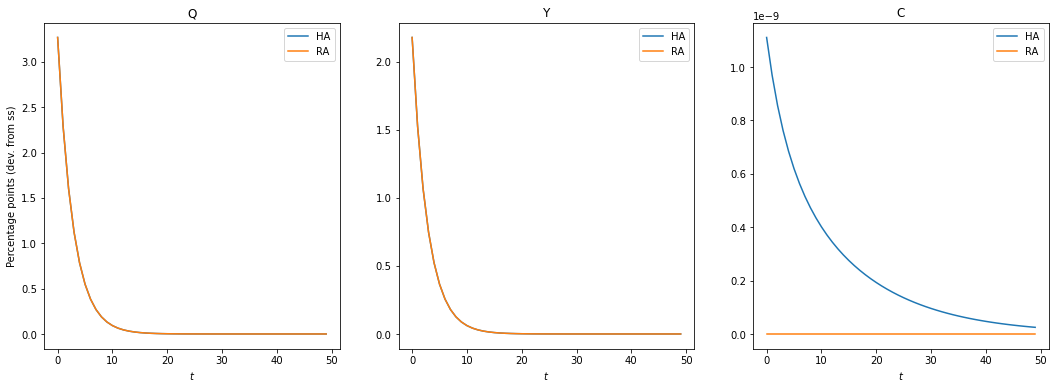

In [201]:
show_irfs([irfs_ha, irfs_ra], ['Q', 'Y', 'C'], labels=['HA', 'RA'])

Why does consumption not move here? Despite `Y` moving? Let us also plot `Z`, `PH_P`:

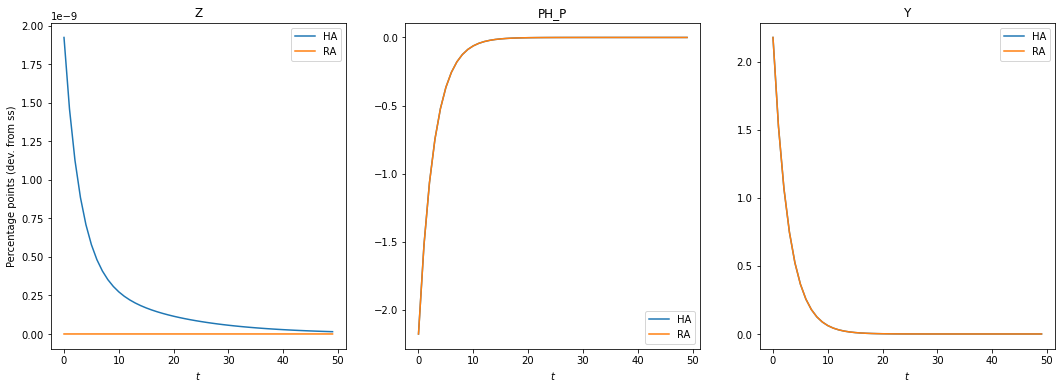

In [202]:
show_irfs([irfs_ha, irfs_ra], ['Z', 'PH_P', 'Y'], labels=['HA', 'RA'])

We see that real labor income Z is constant, because the real value of goods sold, `PH_P` falls due to the depreciation, exactly offsetting the increase in output `Y`.

We can learn more about the propagation by separating the `C` response into what would have happened with only `PH_P` falling ("real income channel") and with only the `Y` increase ("multiplier channel"). We do so by using the `impulse_linear` function.

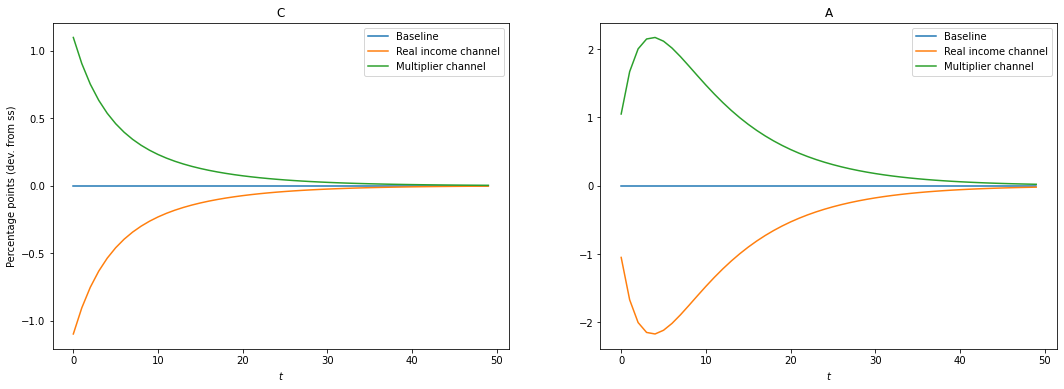

In [203]:
hh_irfs_PH_P = hh_extended.impulse_linear(ss, {'Z': 1 / ss['markup_ss'] * ss['Y'] * irfs['PH_P']})
hh_irfs_Y = hh_extended.impulse_linear(ss, {'Z': 1 / ss['markup_ss'] * irfs['Y'] * ss['PH_P']})
show_irfs([irfs, hh_irfs_PH_P, hh_irfs_Y], ['C', 'A'], labels=['Baseline', 'Real income channel', 'Multiplier channel'])

We see that what's going on is that the real income channel and the multiplier channel are exactly offsetting each other here.

Let's see what happens with greater and smaller `chi`s:

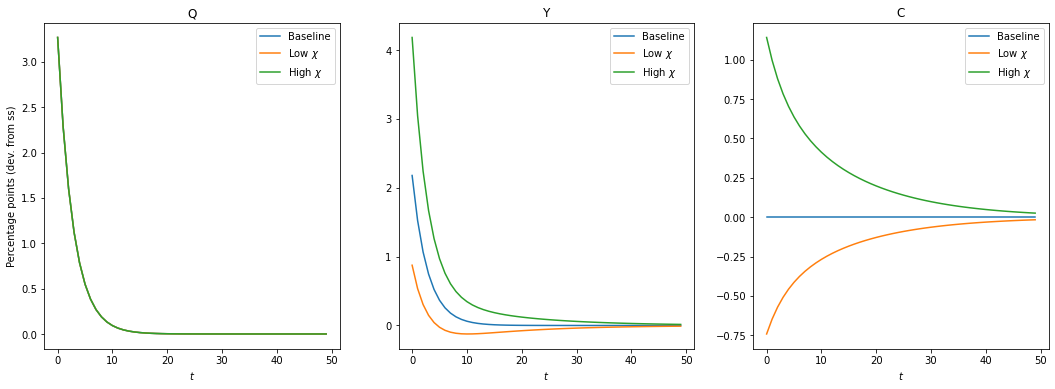

In [204]:
calibration['gamma'] = 0
ss_lowchi = ha.solve_steady_state(calibration, unknowns_ss, targets_ss, dissolve=['UIP'])
irfs_lowchi = ha.solve_impulse_linear(ss_lowchi, unknowns_td, targets_td, shock)

calibration['gamma'] = 1
ss_highchi = ha.solve_steady_state(calibration, unknowns_ss, targets_ss, dissolve=['UIP'])
irfs_highchi = ha.solve_impulse_linear(ss_highchi, unknowns_td, targets_td, shock)

show_irfs([irfs, irfs_lowchi, irfs_highchi], ['Q', 'Y', 'C'], labels=['Baseline', 'Low $\chi$', 'High $\chi$'])

Repeating the decomposition for the case with low chi:

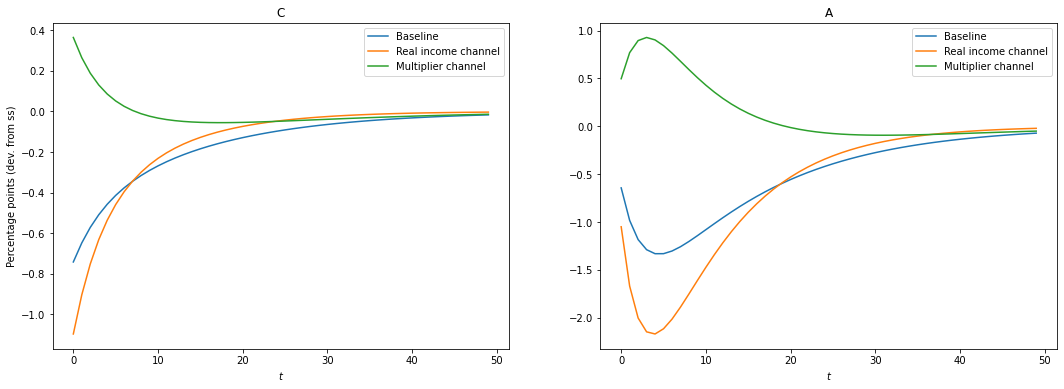

In [205]:
hh_irfs_PH_P = hh_extended.impulse_linear(ss_lowchi, {'Z': 1 / ss_lowchi['markup_ss'] * ss_lowchi['Y'] * irfs_lowchi['PH_P']})
hh_irfs_Y = hh_extended.impulse_linear(ss_lowchi, {'Z': 1 / ss_lowchi['markup_ss'] * irfs_lowchi['Y'] * ss_lowchi['PH_P']})
show_irfs([irfs_lowchi, hh_irfs_PH_P, hh_irfs_Y], ['C', 'A'], labels=['Baseline', 'Real income channel', 'Multiplier channel'])

Here the real income channel dominates!

### Shocks to the domestic interest rate, r

Let's try out a domestic monetary policy shock. For that, let's set chi to 2 - alpha.

chi = 1.6


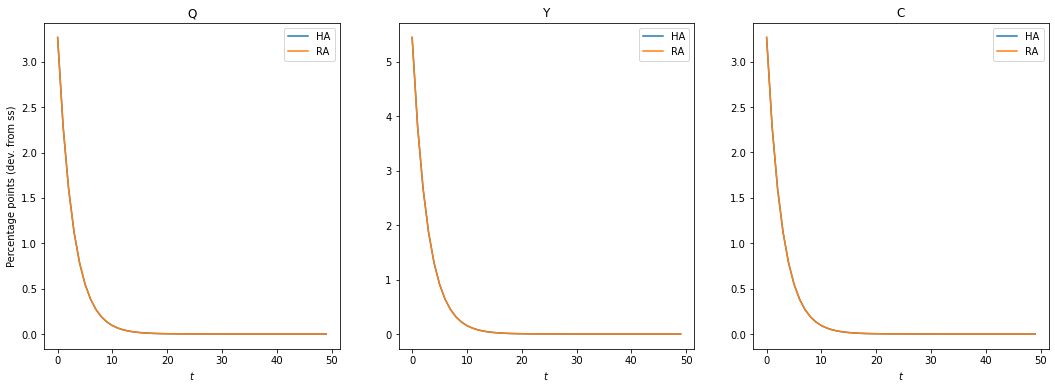

In [207]:
calibration['gamma'] = 2 - calibration['alpha'] - (1 - calibration['alpha']) * calibration['eta']
ss = ha.solve_steady_state(calibration, unknowns_ss, targets_ss, dissolve=['UIP'])
print(f"chi = {ss['chi']}")

irfs_ha = ha.solve_impulse_linear(ss, unknowns_td, targets_td, {'r_ante': -0.01 * 0.70**np.arange(T)})
irfs_ra = ha.solve_impulse_linear(ss, unknowns_td, targets_td, {'r_ante': -0.01 * 0.70**np.arange(T)})

show_irfs([irfs_ha, irfs_ra], ['Q', 'Y', 'C'], labels=['HA', 'RA'])  # try out NX or NFA here too

Notice that `Q` responds exactly the same here as it did to a positive `rstar` shock. But `Y` responds more, because `C` responds more.

Why is that? Let's decompose the `C` response once more.

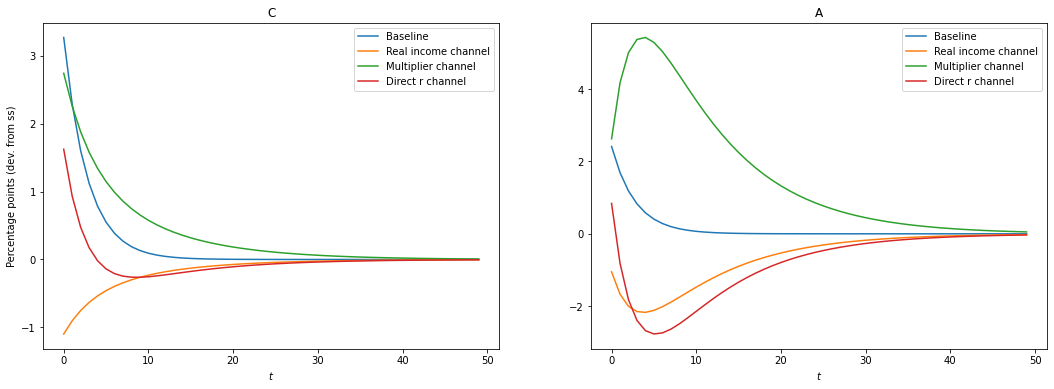

In [208]:
hh_irfs_PH_P = hh_extended.impulse_linear(ss, {'Z': 1 / ss['markup_ss'] * ss['Y'] * irfs['PH_P']})
hh_irfs_Y = hh_extended.impulse_linear(ss, {'Z': 1 / ss['markup_ss'] * irfs['Y'] * ss['PH_P']})
hh_irfs_r = hh_extended.impulse_linear(ss, {'r': irfs['r']})
show_irfs([irfs, hh_irfs_PH_P, hh_irfs_Y, hh_irfs_r], ['C', 'A'], labels=['Baseline', 'Real income channel', 'Multiplier channel', 'Direct r channel'])

## Exercises

### Exercise 1: `Cstar` shocks

Compute the IRFs to an export demand shock, i.e. a shock to `Cstar`. Is there an effect on `C`? If so, why?

### Exercise 2: Domestic demand shocks

Compute the IRFs to a domestic demand shock, i.e. a shock to `beta`.

 (a) How different is a positive demand shock from an accommodative monetary policy shock?

 (b) Decompose the `C` response into the direct effect of the `beta` shock, and the indirect response via `Z`.
 
 (c) Simulate a shock to income risk, i.e. to `sd_e`. How different is a positive risk shock from a negative demand shock?

### Exercise 3: UIP shocks

(a) Modify the model to introduce an exogenous UIP wedge and hit it with a shock. Compare it to the effect of an `rstar` shock, suitably rescaled, with the same persistence.

(b) Now make the UIP wedge endogenous to the NFA: Pick a simple affine linear function for the UIP wedge. How does the endogenous UIP wedge affect the propagation of `rstar` and `r` shocks? What if `chi` is low?

### Exercise 4: MPCs

Add an option to compute MPCs, just like we did before, as `hetoutput`. Compute MPCs in this steady state. Have the model recalibrate the steady state markup `markup_ss` to hit a quarterly MPC of 0.25.

### Exercise 5: Comparison to RA and TA

Just like before, introduce RA and TA models. Compare the HA IRFs to the ones in the RA and TA models. Show that they coincide for `rstar` shocks when `chi=1` but can differ significantly otherwise.

### Exercise 6: Phillips curve and Taylor rule

(a) Introduce a standard wage Phillips curve into the model. Plot the response of nominal wage inflation to an `rstar` shock.

(b) Add a Taylor rule, which pins down the real rate as a function of domestic inflation. How does the response to `rstar` shocks change with a Taylor rule compared to a real rate rule? Interpret.